In [1]:
import os
import shutil
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.rc('font', size=12.0)

import tensorflow as tf
from keras import layers, mixed_precision, regularizers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

2024-10-31 16:30:10.516873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 16:30:10.531809: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 16:30:10.536464: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 16:30:10.548237: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model = ['nl']
label = ['NL']
x_names = ['a', 'alpha', 'param_S', 'param_L', '', 'trans1', '', 'trans2', '']
for k in range(len(model)):
    if model[k] == 'mp' or model[k] == 'np':
        x_names[4], x_names[6], x_names[8] = 'exp1', 'exp2', 'exp3'
    else:
        x_names[4], x_names[6], x_names[8] = 'csq1', 'csq2', 'csq3'
y_names = [f"R_{i}" for i in range(100)]

# Define file directory and load data
dir = '/home/anik/bamr/out/aff_inv/'
mchain = h5py.File(dir + 'nl_all', 'r')['markov_chain_0']

# Prepare X, Y, Z based on loaded data
x_ncols, y_ncols = len(x_names), len(y_names)
nrows, data = mchain['nlines'][0], mchain['data']
X, Y = np.zeros((x_ncols, nrows)), np.zeros((y_ncols, nrows))

for i in range(x_ncols):
    X[i] = data[x_names[i]]
for i in range(y_ncols):
    Y[i] = data[y_names[i]]
Z = np.array(data['R_max']).reshape(-1, 1)  # Shape Z as (nrows, 1)

# Transpose X and Y to shape (nrows, ncols)
X, Y = X.T, Y.T

# Initialize scalers
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))  # Shared scaler for Y and Z

# Fit-transform X
x = scaler_X.fit_transform(X)

# Mask and scale non-zero values in Y
nz = Y != 0
y = np.copy(Y)  # Copy Y to keep zeros intact
y[nz] = scaler_Y.fit_transform(Y[nz].reshape(-1, 1)).flatten() 

# Scale Z with the same scaler as Y
z = scaler_Y.transform(Z)

# Split the data for training and validation as required
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.2, random_state=42)
x_ts, x_vl, y_ts, y_vl = train_test_split(x_ts, y_ts, test_size=0.01, random_state=42)

y_tr2, y_ts2, z_tr, z_ts = train_test_split(y, z, test_size=0.2, random_state=42)
y_ts2, y_vl, z_ts, z_vl = train_test_split(y_ts2, z_ts, test_size=0.01, random_state=42)

In [3]:
# Load model from file
#model = tf.keras.models.load_model("../../models/model_nl.keras")

model1 = tf.keras.models.Sequential([
    layers.Dense(320, activation='relu', input_shape=(x_ncols,)),
    layers.Dense(512, activation='relu'),
    layers.Dense(224, activation='relu'),
    layers.Dense(y_ncols, activation='sigmoid')
])
model1.compile(optimizer='adam', loss='mse')
model1.summary()
batch_size = 128
num_epochs = 1000

# Set up a callback to stop early if given criteria is satisfied
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1.0e-6, 
    patience=10
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    min_lr=1e-6
)

/home/anik/mconda/envs/tfg/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1730406612.686110 2595305 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730406612.741601 2595305 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730406612.741905 2595305 cuda_executor.c

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 320)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 224)            │       114,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        22,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,964 (1.16 MB)

 Trainable params: 304,964 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
training1 = model1.fit(x=x_tr, y=y_tr, batch_size=batch_size, validation_data=(x_ts, y_ts), \
                    epochs=num_epochs, callbacks=[stop_early, lr_schedule], verbose=1)

Epoch 1/1000


I0000 00:00:1730406614.364893 2595437 service.cc:146] XLA service 0x7a4fe8004780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730406614.364935 2595437 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-10-31 16:30:14.409848: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-31 16:30:14.597495: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300
2024-10-31 16:30:15.602338: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_177', 340 bytes spill stores, 292 bytes spill loads

2024-10-31 16:30:15.711650: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in func

42/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0693

I0000 00:00:1730406620.857265 2595437 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-10-31 16:30:22.269308: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_163', 100 bytes spill stores, 100 bytes spill loads

2024-10-31 16:30:22.639191: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_177', 16 bytes spill stores, 16 bytes spill loads

2024-10-31 16:30:22.644358: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_386', 120 bytes spill stores, 120 bytes spill loads

2024-10-31 16:30:22.771788: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled 

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0535

2024-10-31 16:30:29.049742: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 100 bytes spill stores, 100 bytes spill loads

2024-10-31 16:30:29.368795: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 16 bytes spill stores, 16 bytes spill loads



67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - loss: 0.0531 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 2/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 3/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 4/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 5/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2470e-04 - val_loss: 7.6030e-04 - learning_rate: 0.0010
Epoch 6/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2237e-04 - val_loss: 6.4360e-04 - learning_rate: 0.0010
Epoch 7/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1646e-04 - val_loss: 5.7634e-04 - learning_rate: 0.0010
Epoch 8/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4619e-04 - val_loss: 5.1003e-04 - learning_rate: 0.0010
Epoch 9/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7362e-04 - val_loss: 4.4606e-04 - le

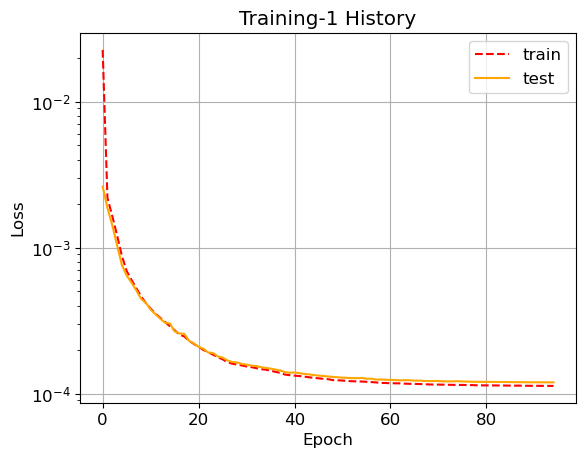

In [5]:
plt.semilogy(training1.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training1.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training-1 History")
plt.legend()
plt.show()

In [19]:
model2 = tf.keras.models.Sequential([
    layers.Dense(1, activation='linear', input_shape=(y_ncols,))
])

model2.compile(optimizer='adam', loss='mse')
model2.summary()

batch_size = 128
num_epochs = 1000

# Set up a callback to stop early if given criteria is satisfied
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1.0e-5, 
    patience=10
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
training2 = model2.fit(x=y_tr2, y=z_tr, batch_size=batch_size, validation_data=(y_ts2, z_ts), \
                    epochs=num_epochs, callbacks=[early_stop, lr_schedule], verbose=1)

Epoch 1/1000


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3372 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 2/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.0069 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 3/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 4/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 5/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 6/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 7/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 8/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 9/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 10/1000
67/67 ━

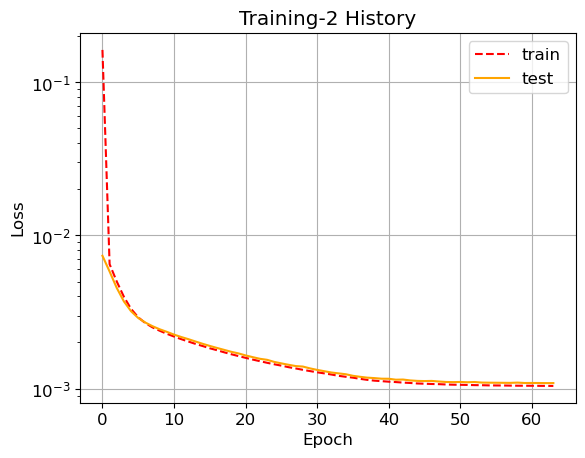

In [21]:
plt.semilogy(training2.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training2.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training-2 History")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[8.39836359e-01 6.73043549e-01 5.67810953e-01 4.92623508e-01
 4.30527866e-01 3.96816909e-01 3.56168449e-01 3.33304793e-01
 3.10831487e-01 2.91183323e-01 2.75439054e-01 2.63757527e-01
 2.50158131e-01 2.41771147e-01 2.39858940e-01 2.31906191e-01
 2.26121098e-01 2.21678659e-01 2.23425940e-01 2.17582285e-01
 2.15163842e-01 2.13068619e-01 2.16827571e-01 2.11822882e-01
 2.14053765e-01 2.17495084e-01 2.15249524e-01 2.17342347e-01
 2.20238224e-01 2.20547646e-01 2.24811330e-01 2.20242605e-01
 2.23412350e-01 2.22153723e-01 2.26926684e-01 2.29879692e-01
 2.29838222e-01 2.29791760e-01 2.33845532e-01 2.34092832e-01
 2.36436501e-01 2.34998286e-01 2.38894388e-01 2.40668327e-01
 2.44532526e-01 2.41716877e-01 2.42015675e-01 2.42800221e-01
 2.47158527e-01 2.45022163e-01 2.48358488e-01 2.46889845e-01
 2.48415098e-01 2.46437863e-01 2.47613251e-01 2.48951152e-01
 2.46670544e-01 2.47314379e-01 2.49859795e-01 2.49516711e-01
 2.41225809e-01 2.43238300e-01 2.39149377e-01 2

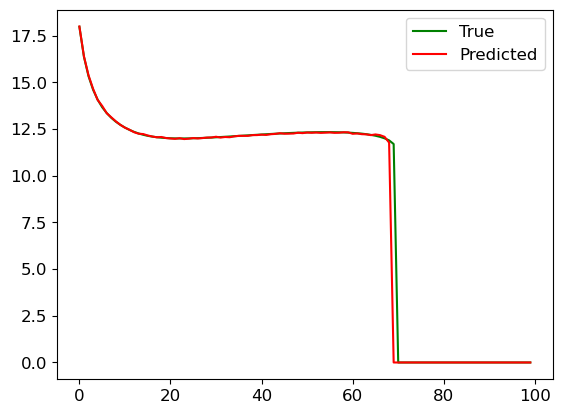

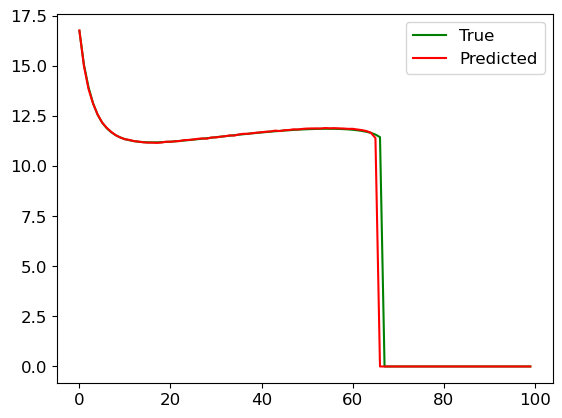

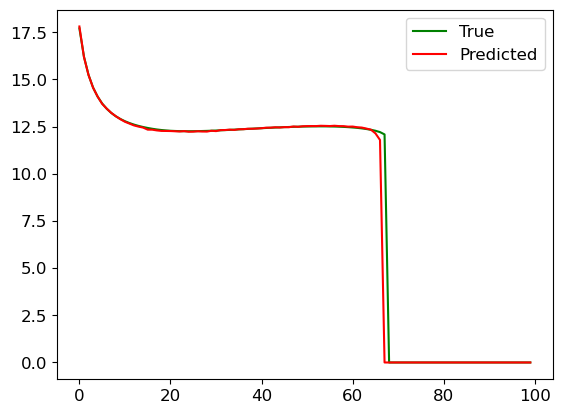

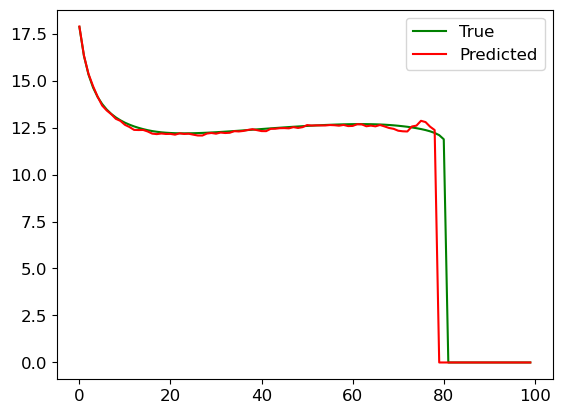

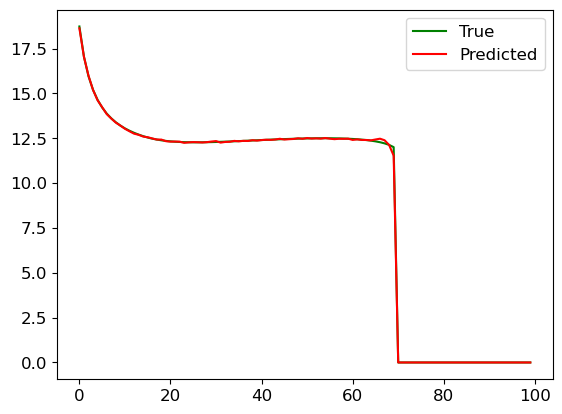

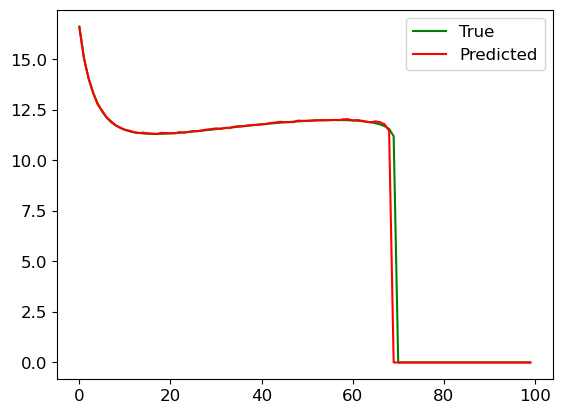

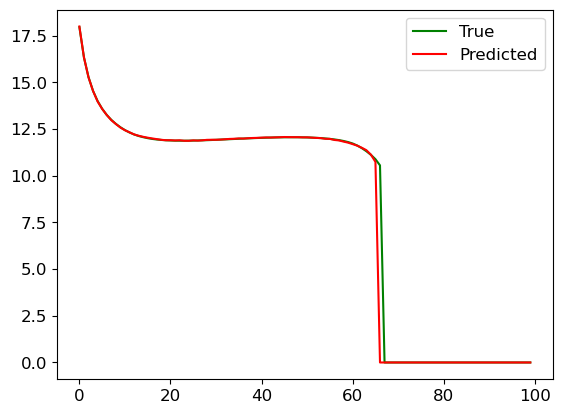

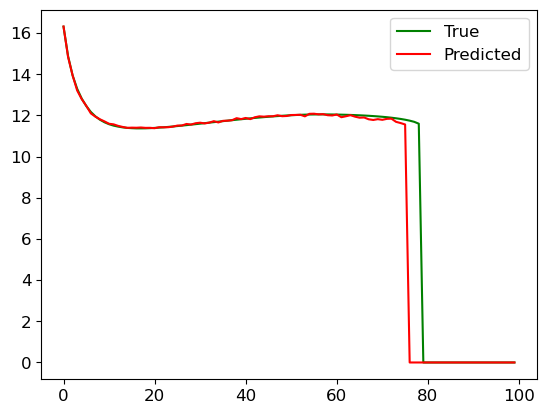

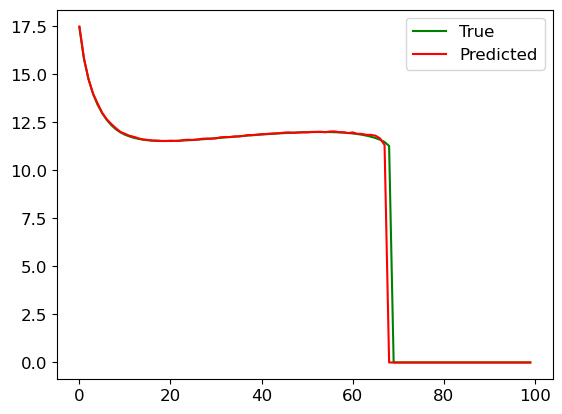

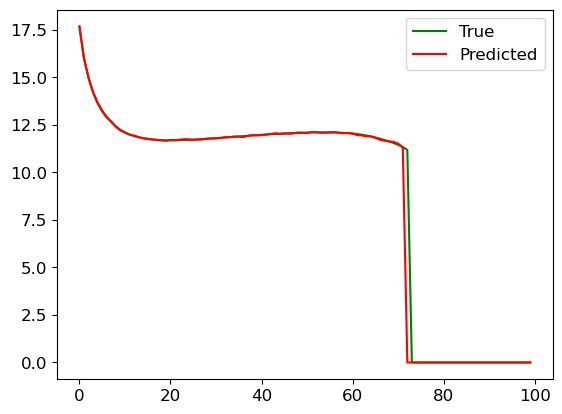

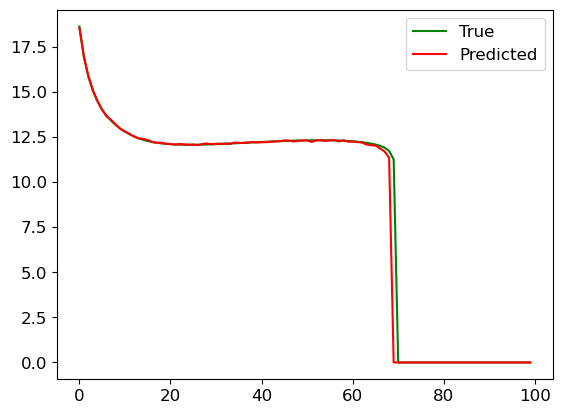

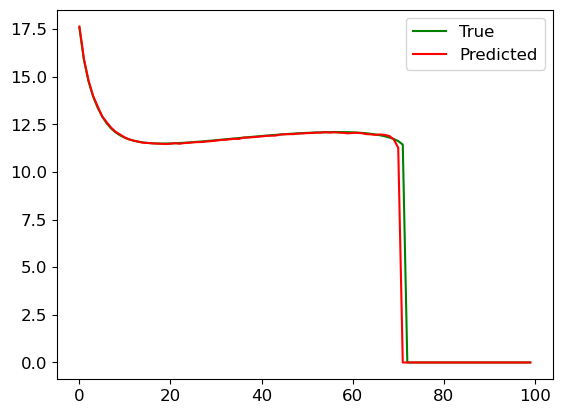

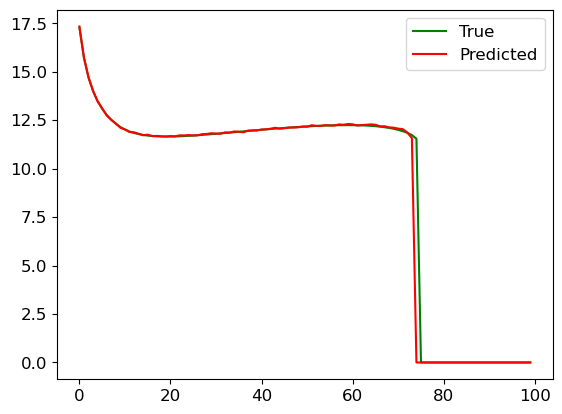

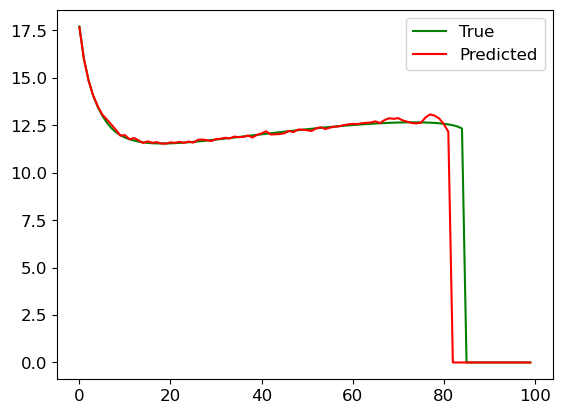

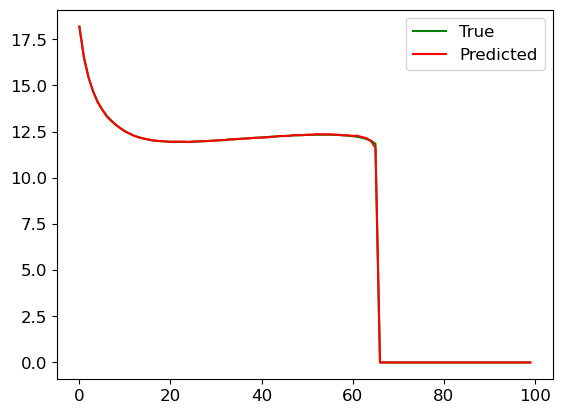

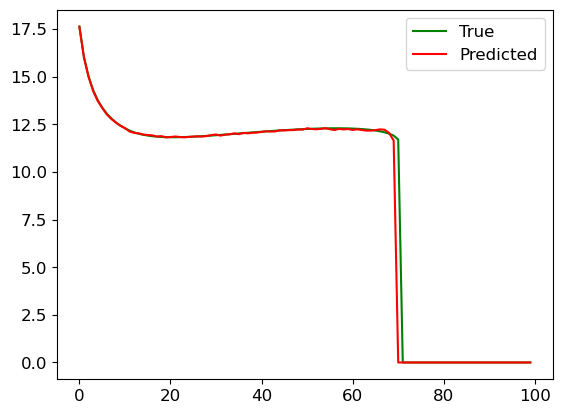

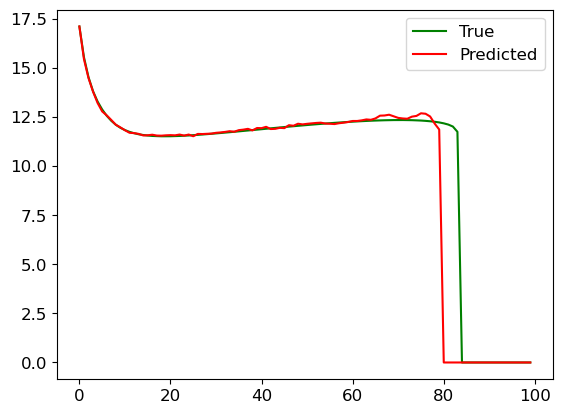

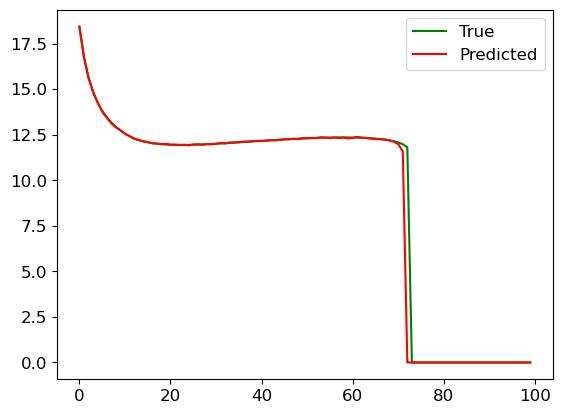

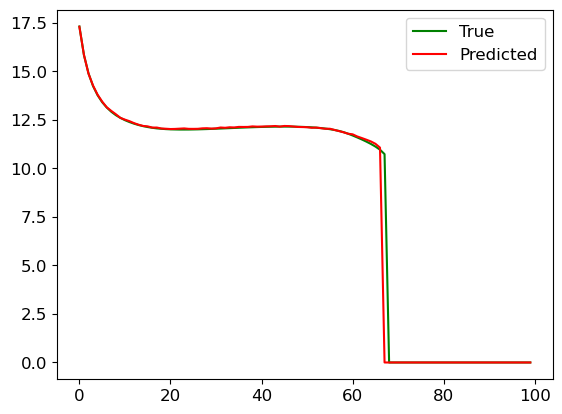

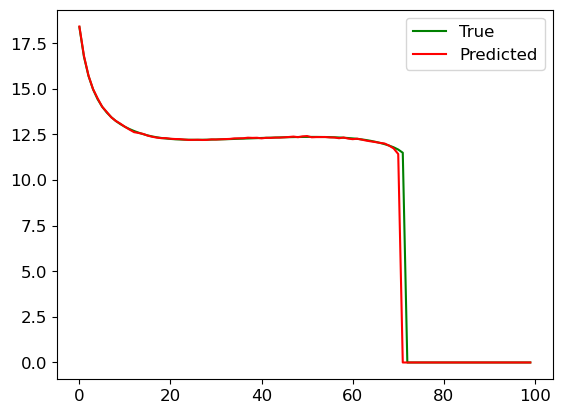

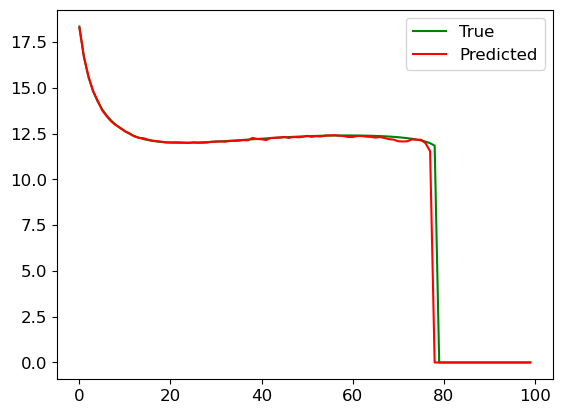

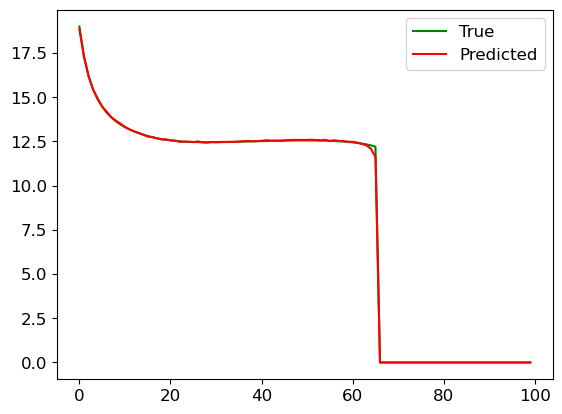

In [ ]:
y_pr = model1.predict(x_vl)
z_pr = model2.predict(y_pr)

# Post-processing loop to zero values in y_pr based on z_pr, starting from the last element
for i in range(len(y_pr)):
    for j in range(len(y_pr[i]) - 1, -1, -1):  # Start from the last element in y_pr[i]
        v = y_pr[i][j]
        if v > z_pr[i]:  # Stop setting to zero once v > z_pr[i]
            break
        y_pr[i][j] = 0  # Set values to zero

nz_pr = y_pr != 0
nz_vl = y_vl != 0

Y_pr = np.copy(y_pr)
Y_vl = np.copy(y_vl)

Y_pr[nz_pr] = scaler_Y.inverse_transform(y_pr[nz_pr].reshape(-1, 1)).flatten()
Y_vl[nz_vl] = scaler_Y.inverse_transform(y_vl[nz_vl].reshape(-1, 1)).flatten()

Y_pr1 = np.copy(Y_pr)

for i in range(y_pr.shape[0]):
    plt.plot(Y_vl[i], label='True', c='green')
    plt.plot(Y_pr[i], label='Predicted', c='red')
    plt.legend()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


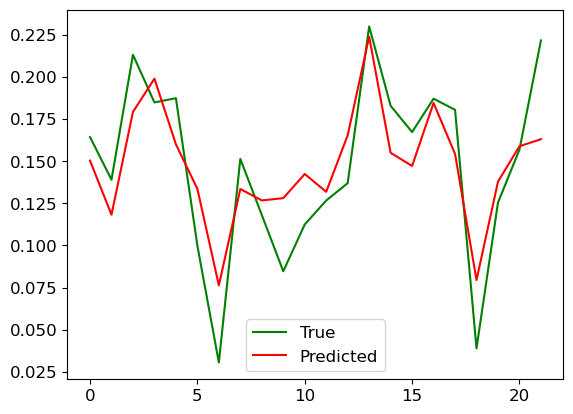

In [10]:
y_pr = model1.predict(x_vl)
z_pr = model2.predict(y_pr)
plt.plot(z_vl, label='True', c='green')
plt.plot(z_pr, label='Predicted', c='red')
plt.legend()
plt.show()

In [11]:
# Step 1: Modify the last value in each X_vl[i] by multiplying it by 1.01
X_vl = scaler_X.inverse_transform(x_vl)  # Inverse transform x_vl to get X_vl

X_vl_modified = np.copy(X_vl)  # Make a copy to avoid altering the original validation set

for i in range(len(X_vl_modified)):
    X_vl_modified[i, -1] *= 1.1  # Multiply the last element by 1.01

# Step 2: Transform the modified X_vl back to x_vl
x_vl_modified = scaler_X.transform(X_vl_modified)

y_pr = model1.predict(x_vl_modified)
z_pr = model2.predict(y_pr)

for i in range(len(y_pr)):
    for j in range(len(y_pr[i]) - 1, -1, -1):
        v = y_pr[i][j]
        if v > z_pr[i]:
            break
        y_pr[i][j] = 0

nz_pr = y_pr != 0
nz_vl = y_vl != 0

Y_pr = np.copy(y_pr)
Y_vl = np.copy(y_vl)

Y_pr[nz_pr] = scaler_Y.inverse_transform(y_pr[nz_pr].reshape(-1, 1)).flatten()
Y_vl[nz_vl] = scaler_Y.inverse_transform(y_vl[nz_vl].reshape(-1, 1)).flatten()

Y_pr2 = np.copy(Y_pr)

for i in range(y_pr.shape[0]):
    i_max1 = np.max(np.nonzero(Y_pr1[i]))
    i_max2 = np.max(np.nonzero(Y_pr2[i]))
    print('imax1 =', i_max1, 'imax2 =',i_max2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
imax1 = 68 imax2 = 68
imax1 = 65 imax2 = 65
imax1 = 66 imax2 = 66
imax1 = 78 imax2 = 78
imax1 = 69 imax2 = 69
imax1 = 68 imax2 = 68
imax1 = 65 imax2 = 65
imax1 = 76 imax2 = 76
imax1 = 67 imax2 = 67
imax1 = 71 imax2 = 71
imax1 = 68 imax2 = 68
imax1 = 70 imax2 = 70
imax1 = 73 imax2 = 73
imax1 = 81 imax2 = 81
imax1 = 65 imax2 = 65
imax1 = 69 imax2 = 69
imax1 = 79 imax2 = 80
imax1 = 71 imax2 = 71
imax1 = 67 imax2 = 67
imax1 = 70 imax2 = 71
imax1 = 77 imax2 = 77
imax1 = 65 imax2 = 65


In [12]:
Z_pr = scaler_Y.inverse_transform(z_pr)
Z_pr[0]

array([11.365612], dtype=float32)

In [13]:
Y_pr[0]

array([17.991196 , 16.391024 , 15.37769  , 14.6567745, 14.065115 ,
       13.736717 , 13.3491   , 13.129495 , 12.914036 , 12.725002 ,
       12.5751915, 12.458258 , 12.330466 , 12.251975 , 12.231344 ,
       12.153031 , 12.100823 , 12.055702 , 12.07252  , 12.017127 ,
       11.995514 , 11.976909 , 12.00987  , 11.96272  , 11.983354 ,
       12.017465 , 11.996248 , 12.014023 , 12.041607 , 12.045806 ,
       12.086209 , 12.042976 , 12.072248 , 12.062678 , 12.10778  ,
       12.13387  , 12.136468 , 12.133407 , 12.174187 , 12.173823 ,
       12.1967   , 12.185968 , 12.2205515, 12.23839  , 12.274693 ,
       12.2492285, 12.251101 , 12.261159 , 12.299921 , 12.279403 ,
       12.314145 , 12.299381 , 12.312603 , 12.294174 , 12.308057 ,
       12.3162565, 12.294698 , 12.300997 , 12.325071 , 12.320545 ,
       12.241832 , 12.263835 , 12.219512 , 12.209486 , 12.167639 ,
       12.20522  , 12.1695   , 12.079954 , 11.775217 ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.    

In [14]:
Z_pr[1]

array([11.063759], dtype=float32)

In [15]:
Y_pr[1]

array([16.759745 , 14.982906 , 13.840727 , 13.11293  , 12.564397 ,
       12.162668 , 11.903194 , 11.697155 , 11.529458 , 11.418071 ,
       11.334063 , 11.298484 , 11.238915 , 11.217041 , 11.177591 ,
       11.161761 , 11.161978 , 11.149719 , 11.166214 , 11.208543 ,
       11.2075   , 11.228154 , 11.242877 , 11.2895355, 11.297788 ,
       11.322934 , 11.353202 , 11.372324 , 11.360972 , 11.422603 ,
       11.424459 , 11.462339 , 11.48429  , 11.524553 , 11.513953 ,
       11.572201 , 11.605266 , 11.604347 , 11.634845 , 11.660829 ,
       11.680892 , 11.711329 , 11.721749 , 11.763701 , 11.7416725,
       11.783732 , 11.794574 , 11.828575 , 11.820324 , 11.849783 ,
       11.864535 , 11.872122 , 11.87179  , 11.871319 , 11.891065 ,
       11.876735 , 11.887586 , 11.873775 , 11.868399 , 11.853291 ,
       11.853254 , 11.819422 , 11.7887745, 11.741151 , 11.657833 ,
       11.392799 ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.    

In [23]:
y_pr[0]

array([0.83983636, 0.67304355, 0.56781095, 0.4926235 , 0.43052787,
       0.3968169 , 0.35616845, 0.3333048 , 0.3108315 , 0.29118332,
       0.27543905, 0.26375753, 0.25015813, 0.24177115, 0.23985894,
       0.23190619, 0.2261211 , 0.22167866, 0.22342594, 0.21758229,
       0.21516384, 0.21306862, 0.21682757, 0.21182288, 0.21405376,
       0.21749508, 0.21524952, 0.21734235, 0.22023822, 0.22054765,
       0.22481133, 0.2202426 , 0.22341235, 0.22215372, 0.22692668,
       0.22987969, 0.22983822, 0.22979176, 0.23384553, 0.23409283,
       0.2364365 , 0.23499829, 0.23889439, 0.24066833, 0.24453253,
       0.24171688, 0.24201567, 0.24280022, 0.24715853, 0.24502216,
       0.24835849, 0.24688984, 0.2484151 , 0.24643786, 0.24761325,
       0.24895115, 0.24667054, 0.24731438, 0.2498598 , 0.24951671,
       0.24122581, 0.2432383 , 0.23914938, 0.2382004 , 0.23386139,
       0.23768799, 0.23383683, 0.22447574, 0.19214661, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [25]:
y_pr = model1.predict(x_vl)
y_pr[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


array([8.39836359e-01, 6.73043549e-01, 5.67810953e-01, 4.92623508e-01,
       4.30527866e-01, 3.96816909e-01, 3.56168449e-01, 3.33304793e-01,
       3.10831487e-01, 2.91183323e-01, 2.75439054e-01, 2.63757527e-01,
       2.50158131e-01, 2.41771147e-01, 2.39858940e-01, 2.31906191e-01,
       2.26121098e-01, 2.21678659e-01, 2.23425940e-01, 2.17582285e-01,
       2.15163842e-01, 2.13068619e-01, 2.16827571e-01, 2.11822882e-01,
       2.14053765e-01, 2.17495084e-01, 2.15249524e-01, 2.17342347e-01,
       2.20238224e-01, 2.20547646e-01, 2.24811330e-01, 2.20242605e-01,
       2.23412350e-01, 2.22153723e-01, 2.26926684e-01, 2.29879692e-01,
       2.29838222e-01, 2.29791760e-01, 2.33845532e-01, 2.34092832e-01,
       2.36436501e-01, 2.34998286e-01, 2.38894388e-01, 2.40668327e-01,
       2.44532526e-01, 2.41716877e-01, 2.42015675e-01, 2.42800221e-01,
       2.47158527e-01, 2.45022163e-01, 2.48358488e-01, 2.46889845e-01,
       2.48415098e-01, 2.46437863e-01, 2.47613251e-01, 2.48951152e-01,
      

In [28]:
Y_pr = scaler_Y.inverse_transform(y_pr)
Y_pr[0]

array([17.991116 , 16.389874 , 15.379619 , 14.6578045, 14.061674 ,
       13.738043 , 13.34781  , 13.128314 , 12.912565 , 12.723939 ,
       12.572792 , 12.460647 , 12.33009  , 12.249573 , 12.2312155,
       12.154868 , 12.09933  , 12.056681 , 12.073455 , 12.017355 ,
       11.994138 , 11.974023 , 12.01011  , 11.962064 , 11.98348  ,
       12.016518 , 11.99496  , 12.015051 , 12.042853 , 12.045823 ,
       12.086756 , 12.042894 , 12.073324 , 12.061242 , 12.107062 ,
       12.135412 , 12.135015 , 12.134568 , 12.173486 , 12.1758585,
       12.1983595, 12.184552 , 12.221955 , 12.238986 , 12.276083 ,
       12.249052 , 12.25192  , 12.259452 , 12.301292 , 12.280783 ,
       12.312812 , 12.298714 , 12.313355 , 12.294374 , 12.305658 ,
       12.318502 , 12.296608 , 12.302789 , 12.327225 , 12.323932 ,
       12.244337 , 12.263658 , 12.224403 , 12.215293 , 12.173637 ,
       12.210374 , 12.173402 , 12.083533 , 11.773168 , 11.131907 ,
       10.452159 , 10.106622 ,  9.968861 ,  9.940234 ,  9.9308